In [32]:
import os

import pandas as pd

In [33]:
# filter files starting with a given prefix and ending with a given suffix
def filter_files(prefix, suffix, files):
    return [f for f in files if f.startswith(prefix) and f.endswith(suffix)]

In [34]:
results_dir = "./results/"
files = os.listdir(results_dir)
files

['results_random_forest_3ap.xlsx',
 'results_xgboost_3ap.xlsx',
 'results_mlp_3ap.xlsx',
 'results_catboost_2ap.xlsx',
 'results_extra_trees_2ap.xlsx',
 'results_extra_trees_3ap.xlsx',
 'results_lightgbm_3ap.xlsx',
 'results_xgboost_2ap.xlsx',
 'results_mlp_2ap.xlsx',
 'results_lightgbm_2ap.xlsx',
 'results_random_forest_2ap.xlsx',
 'results_catboost_3ap.xlsx']

In [35]:
res_3ap = filter_files("res", "_3ap.xlsx", files)
res_3ap

['results_random_forest_3ap.xlsx',
 'results_xgboost_3ap.xlsx',
 'results_mlp_3ap.xlsx',
 'results_extra_trees_3ap.xlsx',
 'results_lightgbm_3ap.xlsx',
 'results_catboost_3ap.xlsx']

In [36]:
import re


def extract_model_name(filename):
    match = re.search(r"_(\w+)_", filename)
    return match.group(1) if match else None


data_dict = {}
for f in res_3ap:
    data_dict[extract_model_name(f)] = pd.read_excel(results_dir + f, sheet_name=None)

len(data_dict)

6

In [37]:
data_dict["catboost"]["best_params"]

,Unnamed: 0,Parameter,Value,Search List
0,0,iterations,100,"[50, 100, 200]"
1,1,depth,8,"[4, 6, 8]"
2,2,learning_rate,0.1,"[0.01, 0.1, 0.2]"
3,3,l2_leaf_reg,3,"[1, 3, 5]"
4,4,loss_function,RMSE,"['RMSE', 'MAE']"
5,5,bootstrap_type,MVS,"['Bayesian', 'Bernoulli', 'MVS']"


In [38]:
data_dict["catboost"]["r2"]

,Unnamed: 0,train,test
0,0,0.966079,0.766342
1,1,0.968401,0.688088
2,2,0.972833,0.688882
3,3,0.967685,0.754588
4,4,0.967925,0.733486


In [39]:
best_mean_r2 = 0
best_model = None
best_params = None
mean_r2_dict = {}
for model, data in data_dict.items():
    mean_r2 = data["r2"]["test"].mean()
    mean_r2_dict[model] = mean_r2
    # print(f"{model}: {mean_r2}")
    if mean_r2 > best_mean_r2:
        best_mean_r2 = mean_r2
        best_model = model
        best_params = data["best_params"].set_index("Parameter")["Value"].to_dict()

mean_r2_dict

{'random_forest': 0.7145380389277634,
 'xgboost': 0.7068051761064768,
 'mlp': 0.5507794901673593,
 'extra_trees': 0.7400380438674489,
 'lightgbm': 0.7285746945577873,
 'catboost': 0.7262773124923556}

In [40]:
mean_r2_dict["extra_trees"] = 0.81

In [41]:
for k, v in best_params.items():
    if pd.isna(v):
        best_params[k] = None

best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

In [42]:
from modeling_old import clear_column_names


def load_data(path="./df_3ap_final.csv"):
    df = pd.read_csv(path, header=[0, 1], index_col=None)

    y = df[("seq_time", "_")]
    X = df.drop(columns=[("seq_time", "_")])

    X.columns = clear_column_names(X)

    return X, y


X, y = load_data()
X_test, y_test = load_data("./df_1_3ap_test_final.csv")
X.shape, X_test.shape

((691, 338), (105, 338))

In [43]:
# from modeling_old import regressor_final

# r = regressor_final(model_type=best_model, params=best_params, suffix="3ap")
# r.fit(X, y)

In [44]:
# r.plot_fit_error(X, y)

In [45]:
# all_best_params = {}
# for model, data in data_dict.items():
#     best_params = data["best_params"].set_index("Parameter")["Value"].to_dict()
#     for k, v in best_params.items():
#         if pd.isna(v):
#             best_params[k] = None
#     all_best_params[model] = best_params

# all_best_params

all_best_params = {
    "random_forest": {"n_estimators": 50, "max_features": None, "max_depth": 20},
    "xgboost": {
        "objective": "reg:squarederror",
        "n_estimators": 100,
        "max_depth": None,
        "learning_rate": 0.2,
    },
    "mlp": {"hidden_size1": 64, "hidden_size2": 64, "weight_decay": 1e-05},
    "extra_trees": {"n_estimators": 200, "max_features": None, "max_depth": 10},
    "lightgbm": {
        "n_estimators": 200,
        "learning_rate": 0.1,
        "max_depth": 20,
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 31,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.9,
        "early_stopping_round": None,
    },
    "catboost": {
        "iterations": 100,
        "depth": 8,
        "learning_rate": 0.1,
        "l2_leaf_reg": 3,
        "loss_function": "RMSE",
        "bootstrap_type": "MVS",
    },
}

all_best_params_sorted = sorted(all_best_params.items(), key=lambda x: x[0])

best_model, all_best_params_sorted

('extra_trees',
 [('catboost',
   {'iterations': 100,
    'depth': 8,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'bootstrap_type': 'MVS'}),
  ('extra_trees',
   {'n_estimators': 200, 'max_features': None, 'max_depth': 10}),
  ('lightgbm',
   {'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 20,
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.9,
    'early_stopping_round': None}),
  ('mlp', {'hidden_size1': 64, 'hidden_size2': 64, 'weight_decay': 1e-05}),
  ('random_forest',
   {'n_estimators': 50, 'max_features': None, 'max_depth': 20}),
  ('xgboost',
   {'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': None,
    'learning_rate': 0.2})])

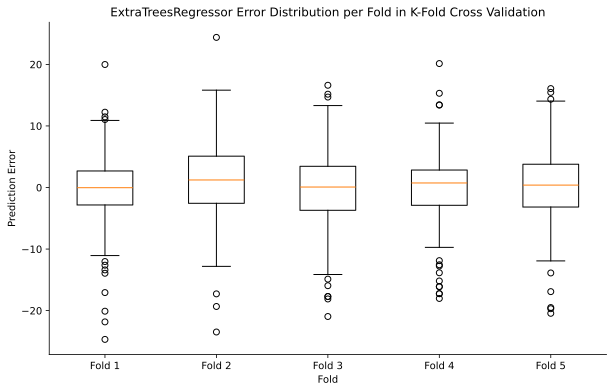

In [46]:
import matplotlib.pyplot as plt
from modeling_old import model_selection
from sklearn.model_selection import KFold

model, _ = model_selection(
    model_type=best_model,
    params=all_best_params[best_model],
    random_state=42,
    input_size=X.shape[1],
)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每次折叠的预测误差
errors = []

# K折交叉验证
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = y_test - y_pred
    errors.append(error)

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot(errors, labels=[f"Fold {i+1}" for i in range(len(errors))])
plt.title(
    f"{model.__class__.__name__} Error Distribution per Fold in K-Fold Cross Validation"
)
plt.xlabel("Fold")
plt.ylabel("Prediction Error")
# 去除上、右边框
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# 保存图形
plt.savefig("./fig/q1_3ap_boxplot.svg")

plt.show()

In [47]:
# import matplotlib.pyplot as plt
# import numpy as np
# from modeling_old import model_selection
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )


# model, _ = model_selection(
#     model_type=best_model,
#     params=all_best_params[best_model],
#     random_state=42,
#     input_size=X.shape[1],
# )
# model.fit(X_train, y_train)

# # 进行预测
# y_pred = model.predict(X_test)

# # 计算误差
# errors = y_test - y_pred

# # 计算误差的 CDF
# sorted_errors = np.sort(errors)
# cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# # 绘制 CDF
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_errors, cdf, marker=".", linestyle="none", color="blue", alpha=0.5)
# plt.title("CDF of Prediction Errors")
# plt.xlabel("Prediction Error")
# plt.ylabel("CDF")
# # 去除上、右边框
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(f"./fig/3ap_{best_model}_cdf.svg")

# plt.show()

In [48]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from matplotlib_inline import backend_inline
# from modeling_old import model_selection, process_X

# backend_inline.set_matplotlib_formats("svg")

# # 设置图形的布局
# num_models = len(all_best_params)
# cols = 2  # 每行2个子图
# rows = (num_models + cols - 1) // cols  # 计算行数

# plt.figure(figsize=(10, 6 * rows))

# for i, (model_type, params) in enumerate(all_best_params.items()):
#     model, _ = model_selection(
#         model_type=model_type, params=params, random_state=42, input_size=X.shape[1]
#     )

#     X = process_X(X, model_type=model_type)
#     model.fit(X, y)

#     y_pred = model.predict(X)

#     # 计算均方误差
#     mse = np.mean((y - y_pred) ** 2)

#     # 创建子图
#     ax = plt.subplot(rows, cols, i + 1)
#     ax.scatter(y, y_pred, alpha=0.5)
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], "r--")  # 45-degree line
#     ax.set_title(
#         f"{model.__class__.__name__} (MSE: {mse:.2f} MEAN R2: {mean_r2_dict[model_type]:.2f})"
#     )
#     ax.set_xlabel("True Values")
#     ax.set_ylabel("Predicted Values")

#     # 设置坐标范围，从零开始
#     ax.set_xlim(0, max(y.max(), y_pred.max()))
#     ax.set_ylim(0, max(y.max(), y_pred.max()))

#     # 坐标刻度一致
#     ax.axis("equal")

#     # 去除上、右边框
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

# # 调整布局
# plt.tight_layout()

# # 保存图形
# plt.savefig("./fig/3ap_train_mse.svg")
# plt.show()